# HR Analytics Employee Attrition

> Source: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/data

這個作品將針對各種變因和員工離職與否進行分析。  
This portfolio will focus on analyzing various factors in relation to employee attrition.

# Data Import & Initial Exoplore

In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from statsmodels.stats.proportion import proportions_ztest as pro_z
from scipy.stats import ttest_ind, chi2_contingency

In [2]:
#Read file
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

df.head(3)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0


因為發現似乎有許多欄位，所以另外確認  
We noticed there were too many columns, so we took an additional look.

In [3]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

## Remove Unimportant Columns

In [4]:
df.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis = 1, inplace = True)

## Check Null

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeNumber            1470 non-null   int64 
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  HourlyRate                1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 
 13  JobLevel                  1470 non-null   int64 
 14  JobRole                 

沒有缺失值！  
No missing values found!

# EDA

## Employee Attrition Distribution

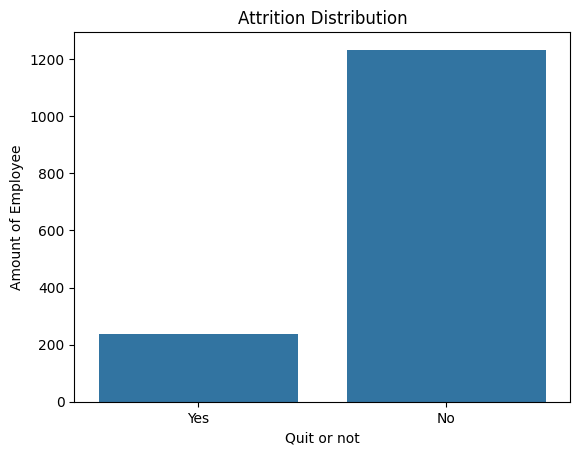

In [15]:
sns.countplot( x= 'Attrition', data = df)
plt.title('Attrition Distribution')
plt.xlabel('Quit or not')
plt.ylabel('Amount of Employee')

plt.show()


進行檢定，以確認此公司的離職率是否顯著高於美國平均。  
Checking whether the attrition rate is significantly higher than the average in the U.S.

> 資料來源： https://datatrack.trendforce.com.tw/Chart/content/2381/united-states-resignment-rate-total

In [24]:
count = df["Attrition"].value_counts()['Yes']

nobs = len(df)

value = 0.032  #資料來源中2025/5, 美國離職率為3.2%

z_stat, p_value = pro_z(count, nobs, value, alternative = 'larger')

print(f"Z Statistics: {z_stat:.3f}")
print(f"p-value: {p_value:.4f}")


Z Statistics: 13.473
p-value: 0.0000


因為Z統計量遠大於1.96, 且p-value遠小於0.05, 因此我們拒絕虛無假設，此公司離職率顯著高於平均水準，需要針對此問題進行處理。  
With a Z-statistic of 13.47 and a p-value < 0.001, we reject the null hypothesis at the 5% significance level and conclude that the employee attrition rate in this company is significantly higher than the national average of 3.2%.

## Determine Whether the Variables have Significant Correlation with Attrition

確認各變數是否和離職率有顯著關係

In [40]:
#分類欄位
categorical_cols = df.select_dtypes(include = 'object').columns.to_list()
numerical_cols = df.select_dtypes(exclude = 'object').columns.to_list()

#移除此處分析無意義之變數
categorical_cols = [col for col in categorical_cols if col != 'Attrition' and df[col].nunique() > 1]  #移除離職自己和值都一樣的欄位
numerical_cols = [col for col in numerical_cols if col != 'EmployeeNumber'] #移除無關數值欄位

#儲存結果用的變數
results_cat = []
results_num = []

#類別型變數卡方檢定
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['Attrition'])
    if contingency_table.shape[0] > 1:
        chi2, p, _, _ = chi2_contingency(contingency_table)
        results_cat.append((col, "Chi-Square", p))

#數值型變數T test
for col in numerical_cols:
    group_yes = df[ df['Attrition'] == 'Yes'][col]
    group_no = df[ df['Attrition'] == 'No'][col]

    t_stat, p, = ttest_ind(group_yes, group_no, equal_var = False)
    results_num.append((col, "T-test", p))

#整理排序
results_cat_df = pd.DataFrame(results_cat, columns = ['Variable','Test Type', 'P-value'])
results_cat_df['Significant(p < 0.05)'] = results_cat_df["P-value"] < 0.05
results_cat_df.sort_values("P-value", inplace = True)

results_num_df = pd.DataFrame(results_num, columns = ['Variable','Test Type', 'P-value'])
results_num_df['Significant(p < 0.05)'] = results_num_df["P-value"] < 0.05
results_num_df.sort_values("P-value", inplace = True)

results_num_df


,Variable,Test Type,P-value,Significant(p < 0.05)
9,MonthlyIncome,T-test,4.433589e-13,True
7,JobLevel,T-test,9.844803e-13,True
16,TotalWorkingYears,T-test,1.159817e-11,True
20,YearsInCurrentRole,T-test,3.187390e-11,True
22,YearsWithCurrManager,T-test,1.185022e-10,True
0,Age,T-test,1.379760e-08,True
19,YearsAtCompany,T-test,2.285905e-07,True
15,StockOptionLevel,T-test,2.811541e-07,True
6,JobInvolvement,T-test,4.681195e-06,True
8,JobSatisfaction,T-test,1.052049e-04,True


根據卡方檢定和T檢定的分析結果，在「單變因」的條件下，如上表，知道各變數與員工離職之間的關係是否具有統計顯著性，並製成以下圖表供參考  
According to the results of the Chi-square test and T-test shown in the table above, we can determine whether each factor is significantly correlated with attrition under a univariate condition. A corresponding plot is provided below for your reference.


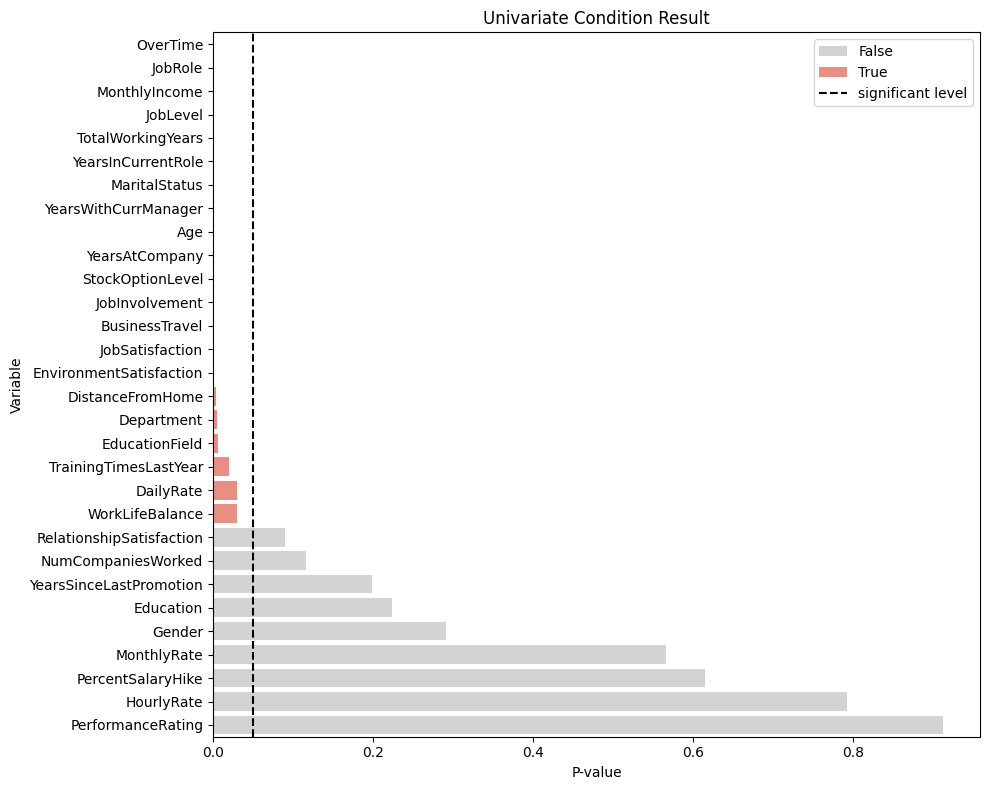

In [43]:
summary_df = pd.concat([results_cat_df, results_num_df])

plt.figure(figsize = (10, 8))
sns.barplot(
    y = 'Variable',
    x = 'P-value',
    data = summary_df.sort_values("P-value"),
    hue = "Significant(p < 0.05)",
    dodge = False,
    palette = {True: "Salmon", False: "lightgray"}
)

plt.axvline(0.05, color = 'black', linestyle = "--", label = "significant level")
plt.title("Univariate Condition Result")
plt.xlabel("P-value")
plt.ylabel('Variable')
plt.legend()
plt.tight_layout()

plt.show()

# JobLevel with Overtime Analysis

從各項顯著的變因來看，我認為不同職級在超時工作的情況下，對於離職的可能性可能值得探討，故這邊針對這兩個因素進行判斷。  
Among the factors that show a significant correlation with attrition, I believe the relationship between job level and overtime work may reveal something interesting. Therefore, I will conduct further analysis focusing on these two variables.

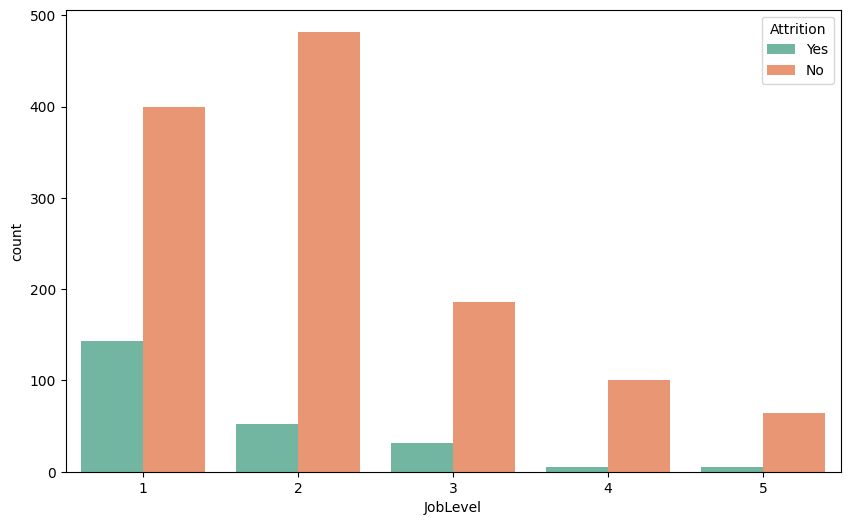

<Figure size 1200x600 with 0 Axes>

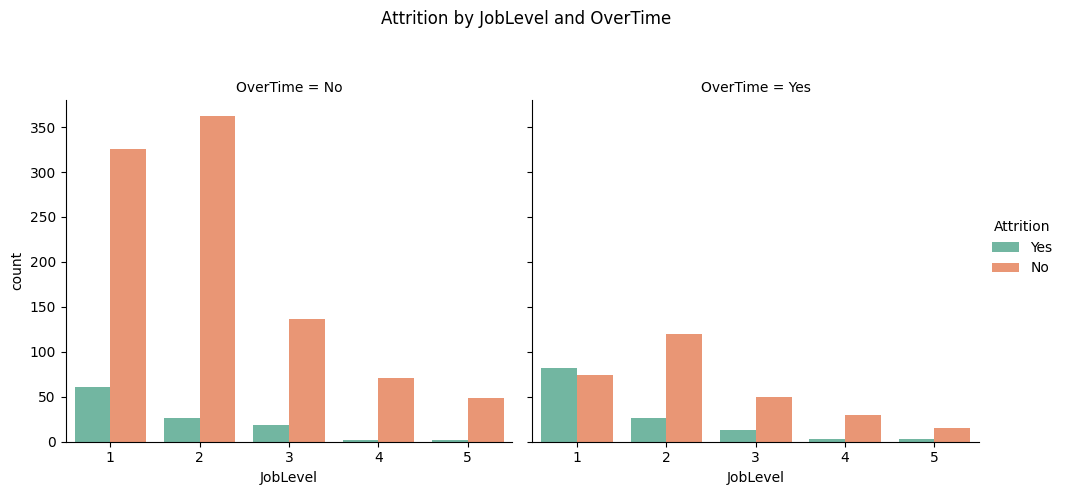

In [48]:
plt.figure(figsize = (10, 6))
sns.countplot(
    data = df,
    x = 'JobLevel',
    hue = 'Attrition',
    palette = 'Set2',
    hue_order = ["Yes", "No"],
    order = sorted(df["JobLevel"].unique()),
    dodge = True
)

plt.figure(figsize = (12, 6))
sns.catplot(
    data = df,
    x = 'JobLevel',
    hue = 'Attrition',
    col = 'OverTime',
    kind = 'count',
    palette = 'Set2',
    col_order = ["No", "Yes"],
    order = sorted(df["JobLevel"].unique())
)

plt.subplots_adjust(top = 0.8)
plt.suptitle("Attrition by JobLevel and OverTime")
plt.show()

從上述的圖表中，我發現初階人力的離職率較高，在加班的情形下，離職人數更是高於留任人數。這樣可能造成初階人才訓練成本增加，且可能引發破窗效應，所以我將會把初階人員留存視為其中一個問題。  
According to the charts above, I observed that lower-level employees tend to have a higher attrition rate. In cases involving overtime work, the number of employees who left even exceeds those who stayed. This may lead to increased training costs for entry-level staff and could potentially trigger a broken window effect. Therefore, I consider improving retention among junior employees as a key issue to address.